# Gene Variant Data Exploration and Modelling
#### Bethany Schoen

9th June 2024

## Notebook objectives
 - Analyse the relationships between personal and lifestyle factors and Familial Hypercholesterolemia (FH)
 - Build a machine learning model to predict the risk of FH using gene variant information

In [1]:
import pandas as pd
import numpy as np
# plotting
%matplotlib widget
from matplotlib import pyplot as plt
import seaborn as sns
# hypothesis testing
from scipy.stats import chi2_contingency, chi2, ttest_ind
# dimensionality reduction
from sklearn.decomposition import PCA
# standardise features
from sklearn.preprocessing import StandardScaler

import data_modelling as dm

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Load and Clean Data

In [2]:
df = pd.read_csv("gene_exp_sythentic_data_candidates.csv")

df.head()

,Disease_state,Age,Sex,Physical_activity,Mental_wellbeing,Var_X100000,Var_X100001,Var_X100002,Var_X100003,Var_X100004,...,Var_X100255,Var_X100256,Var_X100257,Var_X100258,Var_X100259,Var_X100260,Var_X100261,Var_X100262,Var_X100263,Var_X100264
0,Familial_hypercholesterolemia,28,Female,Sedentary,Poor,1.360160,0.030116,0.747095,1.661465,0.434667,...,0.720131,1.962250,0.761477,0.478506,0.832663,0.870216,2.341985,0.391669,-1.075727,0.467369
1,Familial_hypercholesterolemia,20,Male,Sedentary,Poor,1.819418,1.743250,2.302410,2.059035,2.479471,...,1.535071,2.036048,0.730948,-0.045124,0.987104,1.811872,2.569236,1.948865,1.282326,0.919973
2,Familial_hypercholesterolemia,79,Male,Sedentary,Poor,1.856348,1.362939,1.767173,1.740018,1.534536,...,1.145936,1.193780,0.545182,-0.211529,1.016802,1.312096,2.355822,1.798541,0.181833,0.601182
3,Familial_hypercholesterolemia,35,Male,Light intensity,Fair,1.904581,2.196192,2.590662,1.885223,2.490902,...,1.512613,2.043382,0.464402,0.555012,0.291832,2.100558,1.971800,2.168909,1.521835,1.151861
4,Familial_hypercholesterolemia,46,Male,Vigorous intensity,Fair,1.913574,0.951858,1.343247,1.910109,0.265609,...,0.798619,1.431647,1.186902,0.832427,0.467380,1.385796,2.244478,1.293610,-0.063512,0.659144


In [3]:
## initial data cleaning
df["Disease_state"] = df["Disease_state"].fillna("None")
# create a new label column based on the disease_state 
df["label"] = df.apply(lambda row: 0 if row["Disease_state"] == 'None' else 1, axis=1)

# identify null rows
print("Rows with nulls:")
display(df[df.isnull().any(axis=1)])

rows_before = len(df)
# can drop duplicates as we have gene variant information which should be unique for each individual (unless there are twins?)
df = df.drop_duplicates()
rows_after = len(df)
print(f"Number of duplicate rows dropped: {rows_before - rows_after}")

# number of data points per label:
df.groupby(["label"]).Age.count()

Rows with nulls:


,Disease_state,Age,Sex,Physical_activity,Mental_wellbeing,Var_X100000,Var_X100001,Var_X100002,Var_X100003,Var_X100004,...,Var_X100256,Var_X100257,Var_X100258,Var_X100259,Var_X100260,Var_X100261,Var_X100262,Var_X100263,Var_X100264,label


Number of duplicate rows dropped: 0


label
0     548
1    2213
Name: Age, dtype: int64

---

### Statistical Testing to Determine Correlation between Categorical Variables
Here are some examples of how statistical tests can be applied to conclude whether two feature columns are related. Different types of tests are available between categorical and continuous variables. This can help clinicians and stakeholders better understand their patients.

#### Is there a relationship present between the level of physical activity and the mental wellbeing of patients?

In [4]:
def determine_relationship_between_categorical_variables(data, var1, var2, sig_level=0.05):
    """
    Use the Chi Squared test to determine relationships between categorical variables
    """
    # count the occurannces of each combination of variables in our dataset
    contingency_table = pd.crosstab(data[var1], data[var2])
    print("Counts of feature combinations in the dataset:")
    display(contingency_table)

    # use chi squared to compare the frequencies above with the frequencies we would expect if the variables were independent
    chi2_stat, p, dof, expected = chi2_contingency(contingency_table)
    # need frequencies in expected table to be above 5 for chi squared intepretation to be valid
    for i in expected.ravel():
        if i <= 5:
            raise Exception("Expected frequencies too small for chi squared test.")    

    # degrees of freedom and sig level combine to set critical value
    critical_value = chi2.isf(sig_level, dof, loc=0, scale=1)
    print(f"Degrees of Freedom: {dof}")
    print(f"Significance Level: {sig_level}")
    print(f"Critical Value: {critical_value}")
    print(f"Chi-Squared Statistic: {chi2_stat}")
    print(f"P-Value: {p}")
    print(f"\nStatistic greater than critical value? {chi2_stat > critical_value}")
    print(f"Reject Null Hypothesis? {p < sig_level}")

    return

In [5]:
## encode categorical variables so that the order of values is acknowledged in statistical tests
categorical_lookup = {
    "Physical_activity":{
        "Sedentary": 0,
        "Light intensity": 1,
        "Moderate intensity": 2,
        "Vigorous intensity": 3
    },
    "Mental_wellbeing":{
        "Very poor": 0,
        "Poor": 1,
        "Fair": 2,
        "Good": 3,
        "Very good": 4
    }
}

df_encoded = df.copy()
# gender is one hot encoded as we don't want integers to imply order
#df_encoded = pd.get_dummies(df, columns=["Sex"])
# encode columns where categories are ordinal
df_encoded = df_encoded.replace(categorical_lookup)

df_encoded = df_encoded[["Disease_state", "Age", "Sex", "Physical_activity", "Mental_wellbeing", "label"]]
df_encoded.head()

,Disease_state,Age,Sex,Physical_activity,Mental_wellbeing,label
0,Familial_hypercholesterolemia,28,Female,0,1,1
1,Familial_hypercholesterolemia,20,Male,0,1,1
2,Familial_hypercholesterolemia,79,Male,0,1,1
3,Familial_hypercholesterolemia,35,Male,1,2,1
4,Familial_hypercholesterolemia,46,Male,3,2,1


In [6]:
determine_relationship_between_categorical_variables(df_encoded, 'Physical_activity', 'Mental_wellbeing')

Counts of feature combinations in the dataset:


Mental_wellbeing,0,1,2,3,4
Physical_activity,,,,,
0,149,288,281,100,34
1,149,228,217,84,30
2,118,439,228,108,47
3,0,0,158,67,36


Degrees of Freedom: 12
Significance Level: 0.05
Critical Value: 21.026069817483073
Chi-Squared Statistic: 354.8818322170023
P-Value: 1.308633897310668e-68

Statistic greater than critical value? True
Reject Null Hypothesis? True


There is statistically significant evidence to suggest that there is a relationship between mental wellbeing and physical activity. Reject the null hypothesis. 

#### Is there a relationship between FH diagnosis and levels of physical activity?

In [7]:
determine_relationship_between_categorical_variables(df_encoded, 'label', 'Physical_activity')

Counts of feature combinations in the dataset:


Physical_activity,0,1,2,3
label,,,,
0,104,136,225,83
1,748,572,715,178


Degrees of Freedom: 3
Significance Level: 0.05
Critical Value: 7.814727903251178
Chi-Squared Statistic: 64.76890471318265
P-Value: 5.620705950864327e-14

Statistic greater than critical value? True
Reject Null Hypothesis? True


The test above has determined that there is a correlation between FH diagnosis and levels of physical activity. Using this and the Power BI visualisations, we can determine those with FH are less physically active.

#### Do women with FH report to have better mental health than men with FH?

In [8]:
determine_relationship_between_categorical_variables(df_encoded[df_encoded.label==1], 'Sex', 'Mental_wellbeing')

Counts of feature combinations in the dataset:


Mental_wellbeing,0,1,2,3,4
Sex,,,,,
Female,164,428,385,96,10
Male,171,428,404,119,8


Degrees of Freedom: 4
Significance Level: 0.05
Critical Value: 9.487729036781158
Chi-Squared Statistic: 2.2893373128229015
P-Value: 0.6827110366575977

Statistic greater than critical value? False
Reject Null Hypothesis? False


There is no significant evidence to suggest women with FH have better mental health than men with FH. 

Other questions we could explore include "Are patients with diagnosed FH typically older?", "Are men more commonly diagnosed with FH?". 

---

### Statistical Tests to Determine Influential Gene Variants
Other hypothesis testing methods can be used to analyse the relationship between gene variants and the target label (the diagnosis) to determine which variants are most influential on the outcome. 

In [9]:
gene_var_cols = [col for col in list(df.columns) if "Var" in col]
print(f"Number of gene variant columns in the data: {len(gene_var_cols)}")
identified_gene_variants = {}

for col in gene_var_cols:
    diagnosed = df[df['label'] == 1][col]
    not_diagnosed = df[df['label'] == 0][col]

    # dataset has more than 30 points in each group => sample mean is approximately normal (CLT) => use t-test
    # welch's t-test - doesn't assume variances are the same, better on imbalanced datasets
    t_stat, p_value = ttest_ind(diagnosed, not_diagnosed, equal_var=False)

    if p_value < 0.05:
        identified_gene_variants[col] = p_value

print(f"Number of gene variants identified as influential on diagnosis: {len(identified_gene_variants)} ({round(100*len(identified_gene_variants)/len(gene_var_cols), 2)}%)")
print(identified_gene_variants.keys())

Number of gene variant columns in the data: 265
Number of gene variants identified as influential on diagnosis: 31 (11.7%)
dict_keys(['Var_X100234', 'Var_X100235', 'Var_X100236', 'Var_X100237', 'Var_X100238', 'Var_X100239', 'Var_X100240', 'Var_X100241', 'Var_X100242', 'Var_X100243', 'Var_X100244', 'Var_X100245', 'Var_X100246', 'Var_X100247', 'Var_X100248', 'Var_X100249', 'Var_X100250', 'Var_X100251', 'Var_X100252', 'Var_X100253', 'Var_X100254', 'Var_X100255', 'Var_X100256', 'Var_X100257', 'Var_X100258', 'Var_X100259', 'Var_X100260', 'Var_X100261', 'Var_X100262', 'Var_X100263', 'Var_X100264'])


It appears the last 31 columns of gene variants in the dataset can help predict the diagnosis of FH

In [10]:
sorted_identified_gene_variants = {k: v for k, v in sorted(identified_gene_variants.items(), key=lambda item: item[1])}

print("The 5 most influential gene variants (the smaller the p-value, the more confident we are the gene variant influences the diagnosis)")
for i, gv in enumerate(sorted_identified_gene_variants.keys()):
    print(f"{i}: {gv}")
    print(f"     p-value: {sorted_identified_gene_variants[gv]}")
    if i >= 5:
        break

The 5 most influential gene variants (the smaller the p-value, the more confident we are the gene variant influences the diagnosis)
0: Var_X100248
     p-value: 1.0465478708737424e-180
1: Var_X100251
     p-value: 4.007726914623453e-141
2: Var_X100249
     p-value: 1.4930476316735053e-79
3: Var_X100250
     p-value: 1.7808671067464783e-62
4: Var_X100252
     p-value: 7.648785371041764e-62
5: Var_X100261
     p-value: 3.747763224422499e-46


#### Use Dimensionality Reduction to visualise the gene variant data by label
All gene variants:

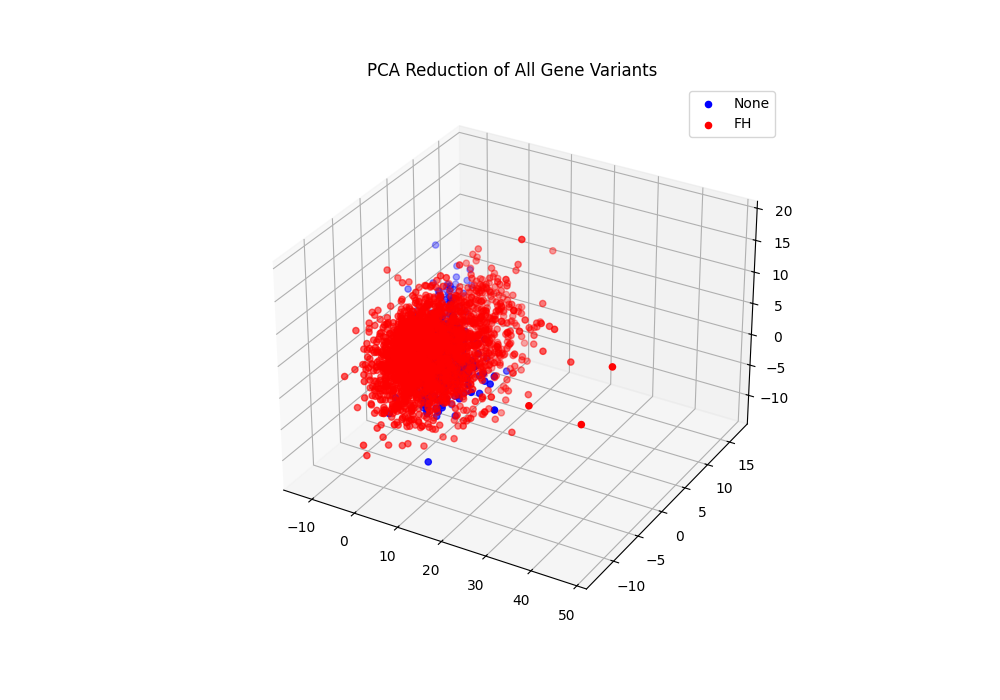

In [11]:
vars = df[gene_var_cols]
# standardise
scaler = StandardScaler()
vars_transformed = scaler.fit_transform(vars)
# dimensionality reduction for visualisation
pca = PCA(n_components=3)
data_3d = pd.DataFrame(pca.fit_transform(vars_transformed))
# add data labels back
data_3d = pd.concat([data_3d, df["label"]], axis=1)

fig = plt.figure(figsize=(10, 7))

diagnosed = data_3d[data_3d["label"] == 1]
not_diagnosed = data_3d[data_3d["label"] == 0]
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(not_diagnosed[0], not_diagnosed[1], not_diagnosed[2], color='b', label="None")
ax1.scatter(diagnosed[0], diagnosed[1], diagnosed[2], color='r', label="FH")
ax1.set_title("PCA Reduction of All Gene Variants")
ax1.legend()

Nothing can be clearly interpreted from this plot, but a blue cluster of patients without FH can be found. This may suggest that some gene variants are adding noise to the predictability of the disease. 

Only the 31 significant gene variants:

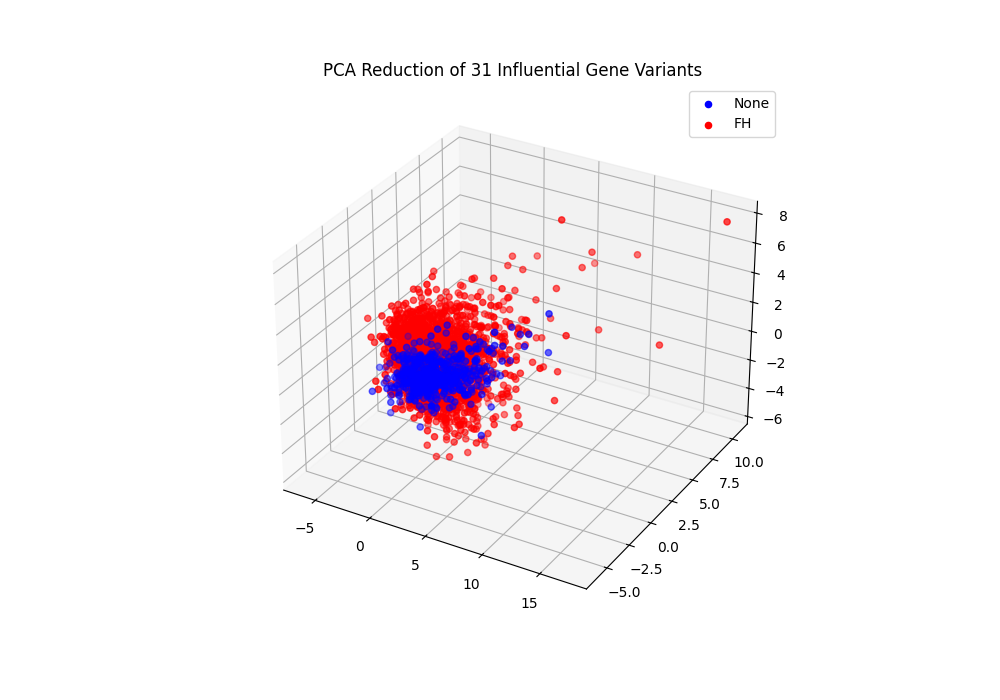

In [12]:
vars = df[list(identified_gene_variants.keys())]
# standardise
scaler = StandardScaler()
vars_transformed = scaler.fit_transform(vars)
# dimensionality reduction for visualisation
pca = PCA(n_components=3)
data_3d = pd.DataFrame(pca.fit_transform(vars_transformed))
# add data labels back
data_3d = pd.concat([data_3d, df["label"]], axis=1)

fig = plt.figure(figsize=(10, 7))

diagnosed = data_3d[data_3d["label"] == 1]
not_diagnosed = data_3d[data_3d["label"] == 0]
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(not_diagnosed[0], not_diagnosed[1], not_diagnosed[2], color='b', label="None")
ax1.scatter(diagnosed[0], diagnosed[1], diagnosed[2], color='r', label="FH")
ax1.set_title("PCA Reduction of 31 Influential Gene Variants")
ax1.legend()

This 3D plot suggests the two clusters of points associated with each label are more easily identifiable when using the 31 influential gene variants. This plot also suggests we may have some outliers in the FH group, but depending on the type of ML model chosen, may not effect the decision boundary created.

---

## Machine Learning
Construct models that can:
 - analyse the relationships between gene variant data and FH diagnoses,
 - predict the presence of FH in a new, undiagnosed patient. 

### Model Training
For simplicity of this exercise, three traditional/popular classification models have been chosen. These can be seen as 'baseline' techniques before considering more complex approaches:
 - K-Nearest Neighbours
 - Logistic Regression
 - XGBoost

#### All Gene Variants Model
Hyperparameter tuning:

In [13]:
gene_var_cols = [col for col in list(df.columns) if "Var" in col]

In [14]:
dm.tune_models_main(df, gene_var_cols, "label")

Attempt  0
## Tuning K-Nearest Neighbours ##
Best Score: 0.981973168820995
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}


Attempt  1
## Tuning K-Nearest Neighbours ##
Best Score: 0.9812524481002741
Best Hyperparameters: {'weights': 'uniform', 'n_neighbors': 9, 'metric': 'manhattan'}


Attempt  2
## Tuning K-Nearest Neighbours ##
Best Score: 0.9812524481002742
Best Hyperparameters: {'weights': 'uniform', 'n_neighbors': 11, 'metric': 'manhattan'}


Attempt  0
## Tuning Logistic Regressor ##
Best Score: 0.9661104582843713
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}


Attempt  1
## Tuning Logistic Regressor ##
Best Score: 0.9661104582843713
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}


Attempt  2
## Tuning Logistic Regressor ##
Best Score: 0.9661104582843713
Best Hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.1}


Attempt  0
## Tuning XGBoost Classifier ##
Best Score: 0.972

Model testing:

## knn ##
Precision and Recall scores in testing

              precision    recall  f1-score   support

           0      0.933     0.994     0.963       181
           1      0.999     0.982     0.990       731

    accuracy                          0.985       912
   macro avg      0.966     0.988     0.976       912
weighted avg      0.986     0.985     0.985       912

ROC Score

0.9883456401962044
F1 Score:
0.9903448275862069

Confusion Matrix


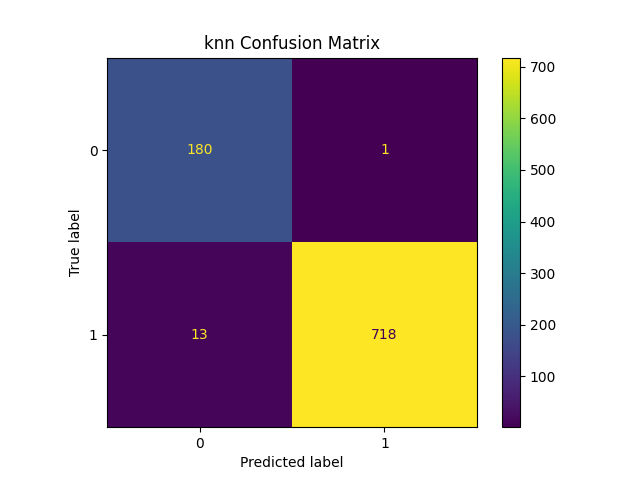

## lr ##
Precision and Recall scores in testing

              precision    recall  f1-score   support

           0      0.919     0.945     0.932       181
           1      0.986     0.979     0.983       731

    accuracy                          0.973       912
   macro avg      0.953     0.962     0.957       912
weighted avg      0.973     0.973     0.973       912

ROC Score

0.9621157726870783
F1 Score:
0.9828414550446122

Confusion Matrix


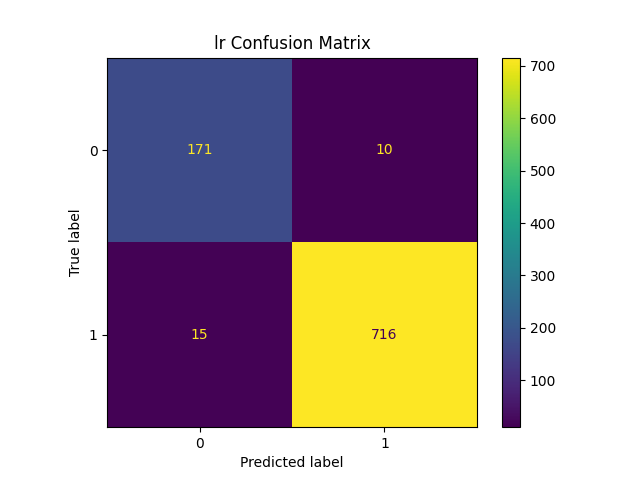

## xgb ##


[22:03:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "solver" } are not used.



Precision and Recall scores in testing

              precision    recall  f1-score   support

           0      0.970     0.895     0.931       181
           1      0.974     0.993     0.984       731

    accuracy                          0.974       912
   macro avg      0.972     0.944     0.957       912
weighted avg      0.974     0.974     0.973       912

ROC Score

0.9440938395144772
F1 Score:
0.983739837398374

Confusion Matrix


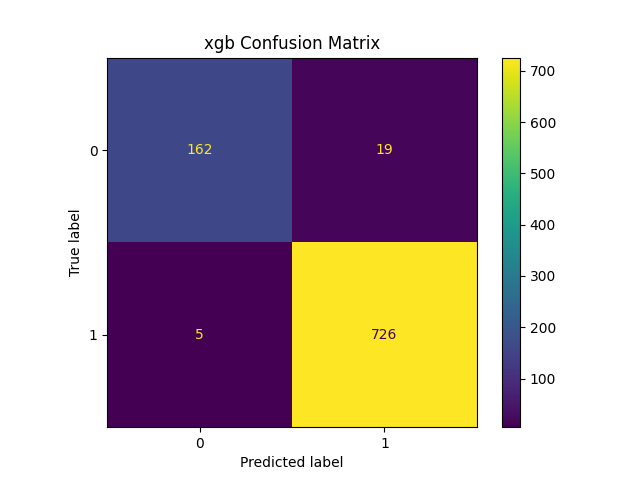

[('knn', 0.9903448275862069), ('lr', 0.9828414550446122), ('xgb', 0.983739837398374)]


In [15]:
params_dict = {
    "lr":{
        'solver': 'newton-cg', 
        'penalty': 'l2', 
        'C': 0.1
    },
    "knn":{
        'weights': 'uniform', 
        'n_neighbors': 11, 
        'metric': 'manhattan'
    },
    "xgb":{
        'min_child_weight': 7, 
        'max_depth': 3, 
        'learning_rate': 0.15, 
        'gamma': 0.3, 
        'colsample_bytree': 0.4
    }
}
dm.compare_models_main(df, gene_var_cols, "label", params_dict=params_dict)

All models performed extremely well on the test data with F1 scores above 0.98! 

We may want to prioritise a model with higher recall/sensitivity as the consequences of false negatives are greater than false positives - we don't want to miss an instance of FH. All models had very good recall scores, but the XGBoost misclassified the least number of positive points. 

Viewing the model coefficients of the logistic regression model can help us understand which gene variants were most influential when defining the decision boundary - the larger the number (away from 0), the more this value influences the output from the model. 

In [16]:
lr_model = dm.modelling_main(df, gene_var_cols, "label", "lr", params_dict["lr"])
model_coeffs = {}
for feature, coef in zip(gene_var_cols, lr_model.coef_.tolist()[0]):
    model_coeffs[feature] = coef

sorted_model_coeffs = {k: v for k, v in sorted(model_coeffs.items(), key=lambda item: abs(item[1]), reverse=True)}

print("The 5 most influential gene variants:")
for i, gv in enumerate(sorted_model_coeffs.keys()):
    print(f"{i}: {gv}")
    print(f"     Model coefficient: {sorted_model_coeffs[gv]}")
    if i >= 5:
        break

The 5 most influential gene variants:
0: Var_X100251
     Model coefficient: 1.434853497339319
1: Var_X100248
     Model coefficient: -1.3926348629466967
2: Var_X100249
     Model coefficient: -0.8571337898968734
3: Var_X100250
     Model coefficient: -0.8186420859829632
4: Var_X100252
     Model coefficient: -0.6667382127258926
5: Var_X100234
     Model coefficient: -0.6599495502462498


Var_X100251, Var_X100248, and Var_X100249 were the most influential. This agrees with the top three identified in the hypothesis testing task. Many of the higher numbered gene variants that were identified in previously have also been highlighted as influential in the LR model. 

[22:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "solver" } are not used.

[22:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


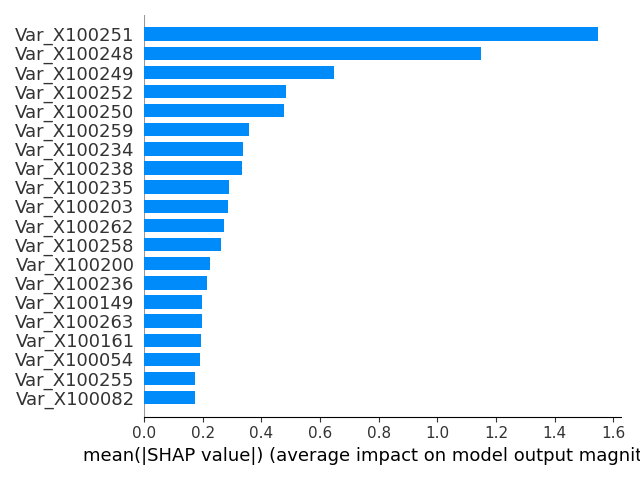

In [17]:
xgb_model = dm.modelling_main(df, gene_var_cols, "label", "xgb", params_dict["xgb"])

Using SHAP to evaluate feature importance in the XGBoost model, the same three gene variants were again identified as the most important. 

#### Influential Gene Variants Model
Does a model focusing on the 31 gene variants identified above perform better than the a model using all gene variant information?

In [18]:
filtered_gv_cols = list(identified_gene_variants.keys())

In [19]:
dm.tune_models_main(df, filtered_gv_cols, "label")

Attempt  0
## Tuning K-Nearest Neighbours ##
Best Score: 0.9650303564433999
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}


Attempt  1
## Tuning K-Nearest Neighbours ##
Best Score: 0.9652095573834704
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}


Attempt  2
## Tuning K-Nearest Neighbours ##
Best Score: 0.9652095573834704
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}


Attempt  0
## Tuning Logistic Regressor ##
Best Score: 0.9507814336075207
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}


Attempt  1
## Tuning Logistic Regressor ##
Best Score: 0.9507814336075207
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}


Attempt  2
## Tuning Logistic Regressor ##
Best Score: 0.9507814336075207
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}


Attempt  0
## Tuning XGBoost Classifier ##
Best Score: 0.9

## knn ##
Precision and Recall scores in testing

              precision    recall  f1-score   support

           0      0.880     0.928     0.903       181
           1      0.982     0.969     0.975       731

    accuracy                          0.961       912
   macro avg      0.931     0.948     0.939       912
weighted avg      0.962     0.961     0.961       912

ROC Score

0.9483565236450484
F1 Score:
0.9752066115702479

Confusion Matrix


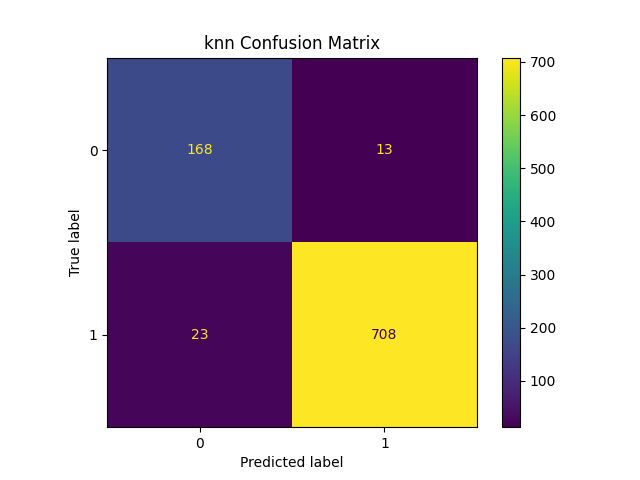

## lr ##
Precision and Recall scores in testing

              precision    recall  f1-score   support

           0      0.888     0.829     0.857       181
           1      0.958     0.974     0.966       731

    accuracy                          0.945       912
   macro avg      0.923     0.901     0.912       912
weighted avg      0.944     0.945     0.944       912

ROC Score

0.9013687448511462
F1 Score:
0.9660786974219809

Confusion Matrix


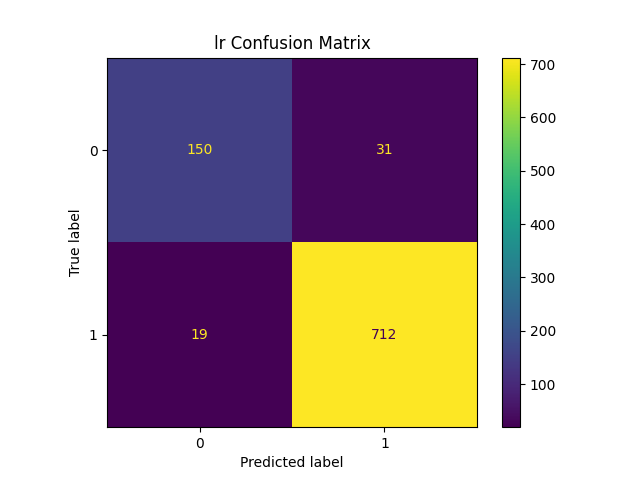

## xgb ##


[22:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "solver" } are not used.



Precision and Recall scores in testing

              precision    recall  f1-score   support

           0      0.953     0.895     0.923       181
           1      0.974     0.989     0.982       731

    accuracy                          0.970       912
   macro avg      0.964     0.942     0.952       912
weighted avg      0.970     0.970     0.970       912

ROC Score

0.942041855930346
F1 Score:
0.9816700610997964

Confusion Matrix


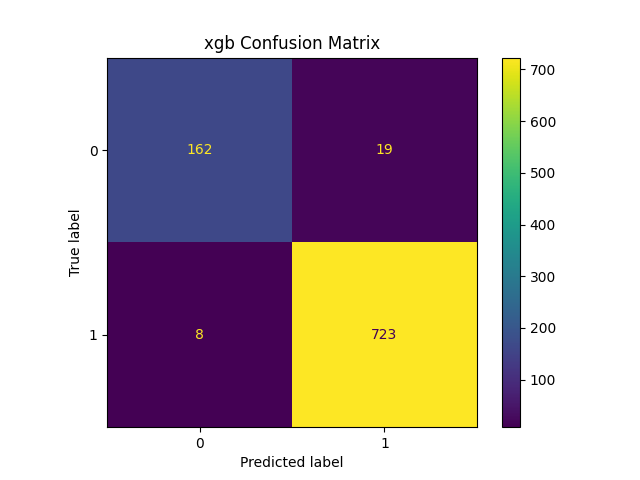

[('knn', 0.9752066115702479), ('lr', 0.9660786974219809), ('xgb', 0.9816700610997964)]


In [20]:
params_dict = {
    "lr":{
        'solver': 'liblinear', 
        'penalty': 'l2', 
        'C': 0.1
    },
    "knn":{
        'weights': 'distance', 
        'n_neighbors': 7, 
        'metric': 'minkowski'
    },
    "xgb":{
        'min_child_weight': 5, 
        'max_depth': 3, 
        'learning_rate': 0.25, 
        'gamma': 0.4, 
        'colsample_bytree': 0.7
    }
}
dm.compare_models_main(df, filtered_gv_cols, "label", params_dict=params_dict)

Interestingly, even though the hypothesis testing saw that these 31 gene variants are the most influential individually on the diagnosis, information is lost when the rest of the gene variants are excluded. This is likely because there are a combination of gene variants that, when inputted together, provide more relevant information to help with the partitioning of data (hypothesis testing fails to check combinations of features).

However, the models were much more efficient in training thanks to the reduced dimensionality. They also performed very well! 

[22:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "solver" } are not used.

[22:08:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


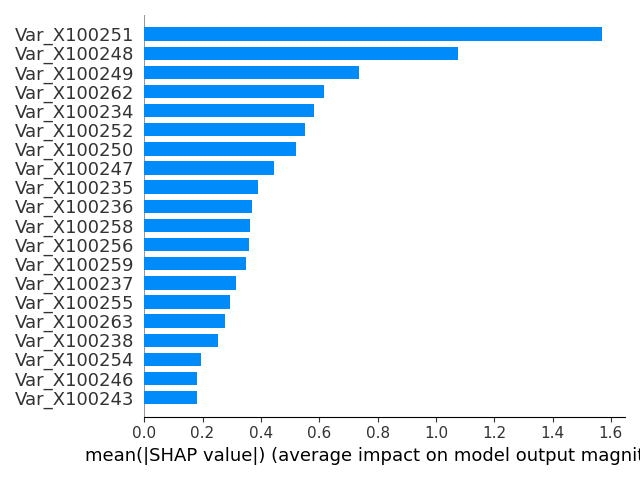

In [21]:
reduced_xgb_model = dm.modelling_main(df, filtered_gv_cols, "label", "xgb", params_dict["xgb"])

The same three gene variants feature at the top of the SHAP summary plot as the most important.